In [ ]:
import requests
import matplotlib.pylab as plt
import time
import matplotlib.image as mpimg
from PIL import Image, ImageSequence
import io
import numpy as np
img_url = ['https://i.imgur.com/hqfXf10.jpg',
           'https://i.imgur.com/bk79Ajj.jpg',
           'https://i.imgur.com/Pt5BM1b.jpg']

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
response = [requests.get(i, stream=True, headers=headers) for i in img_url]
# Check for successful download
img_list = []
for r in response:
    if r.headers['Content-Type'] == 'image/gif':
        img = Image.open(io.BytesIO(r.content))
        frames = [frame.copy() for frame in ImageSequence.Iterator(img)]
        img_list.append(frames[0])  # Only take the first frame of the GIF

    else:
        img_list.append(Image.open(io.BytesIO(r.content)))

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


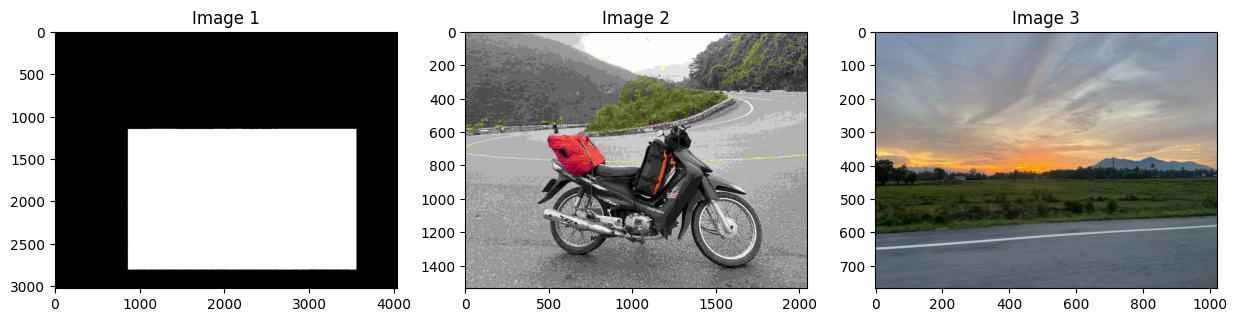

In [ ]:
def gradient_domain_editing(mask, source, target):
    # Chuyển đổi ảnh mask và source sang dạng grayscale
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    source_gray = cv2.cvtColor(source, cv2.COLOR_RGB2GRAY)

    # Tính gradient của source và target
    dx_source, dy_source = np.gradient(source_gray.astype(float))
    dx_target = np.gradient(target.astype(float), axis=1)
    dy_target = np.gradient(target.astype(float), axis=0)
    # Tính toán Laplacian của mask
# Chuyển đổi ảnh mask sang định dạng uint8
    mask_gray_uint8 = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2BGR).astype(np.uint8)

    # Tính Laplacian của mask
    lap_mask = cv2.Laplacian(mask_gray_uint8, cv2.CV_64F)
    # Tính gradient của Laplacian
    grad_lap = np.gradient(lap_mask)

    # Phân tách gradient theo các chiều x và y
    dx_lap = grad_lap[1]  # Gradient theo trục x
    dy_lap = grad_lap[0]

    # Tính gradient của target trong vùng mask
    expanded_mask_gray = np.expand_dims(mask_gray, axis=-1)

    dx_target_masked = dx_target * (1 - expanded_mask_gray / 255.0)
    dy_target_masked = dy_target * (1 - expanded_mask_gray / 255.0)

    flattened_mask_gray = expanded_mask_gray.squeeze()
    flattened_dx_target = dx_target[:, :, 0]
    flattened_dt_target = dy_target[:, :, 0]

# Tính gradient của target trong vùng mask
    dx_target_masked = flattened_dx_target * (1 - flattened_mask_gray / 255.0)
    dy_target_masked = flattened_dt_target * (1 - flattened_mask_gray / 255.0)

    # Thêm gradient của source vào gradient của target trong vùng mask
    dx_target_masked += dx_source * (flattened_mask_gray / 255.0)
    dy_target_masked += dy_source * (flattened_mask_gray / 255.0)

    # Tính toán Laplacian mới từ gradient đã điều chỉnh
    lap_new = cv2.Laplacian(target.astype(float), cv2.CV_64F)

    # Tính toán ảnh mới từ Laplacian đã điều chỉnh
    new_image = target.astype(float) + lap_new - lap_mask

    # Chuyển đổi lại ảnh mới sang dạng uint8
    new_image = np.clip(new_image, 0, 255).astype(np.uint8)

    return new_image
result = gradient_domain_editing(image1, image2, image3)
show_img(result)

NameError: name 'cv2' is not defined

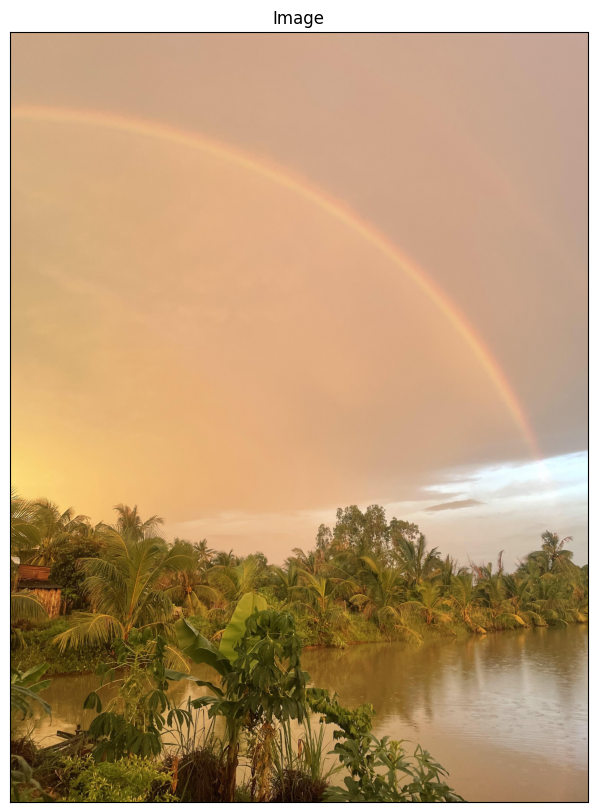

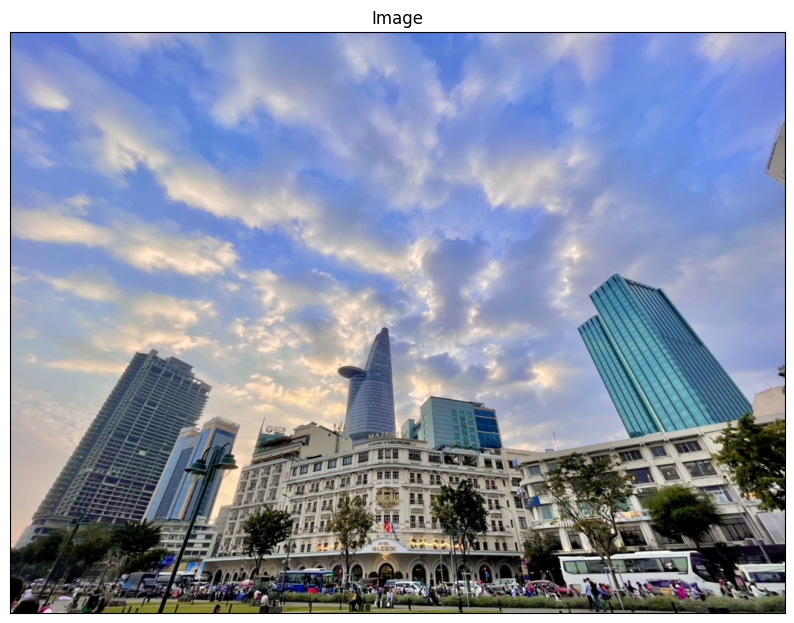

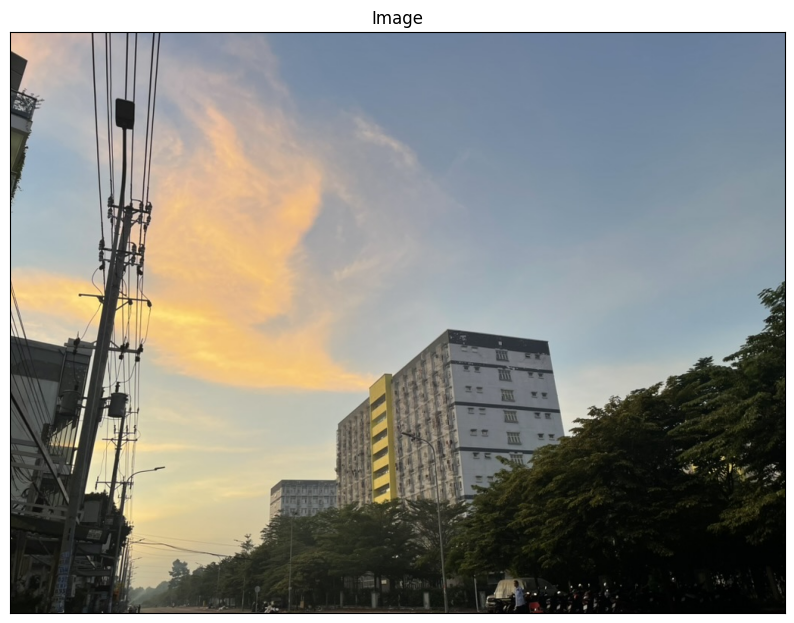

In [ ]:
def show_img(img):
  plt.figure(figsize=(10, 10))
  plt.plot(221), plt.imshow(img), plt.title('Image')
  plt.xticks([]), plt.yticks([])
  plt.show()
for i in img_list:
  show_img(i)


In [ ]:
type(img_list[1])

PIL.JpegImagePlugin.JpegImageFile

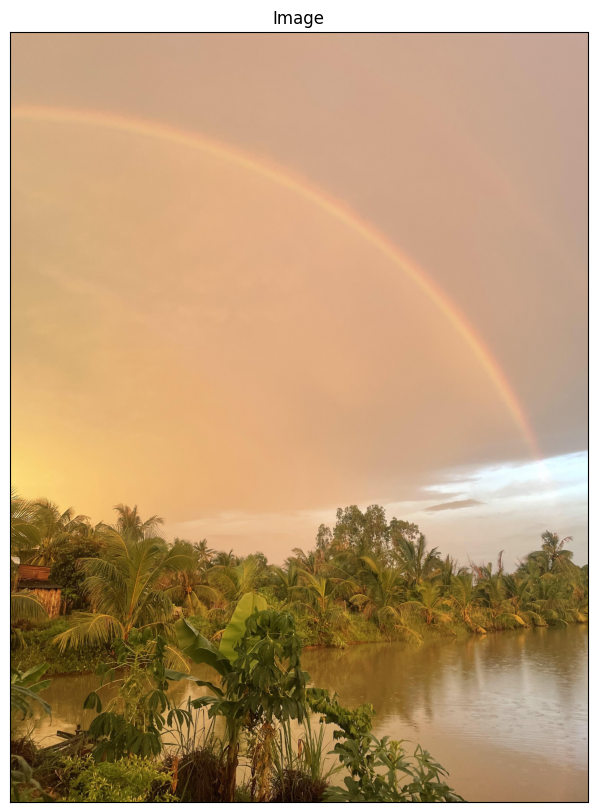

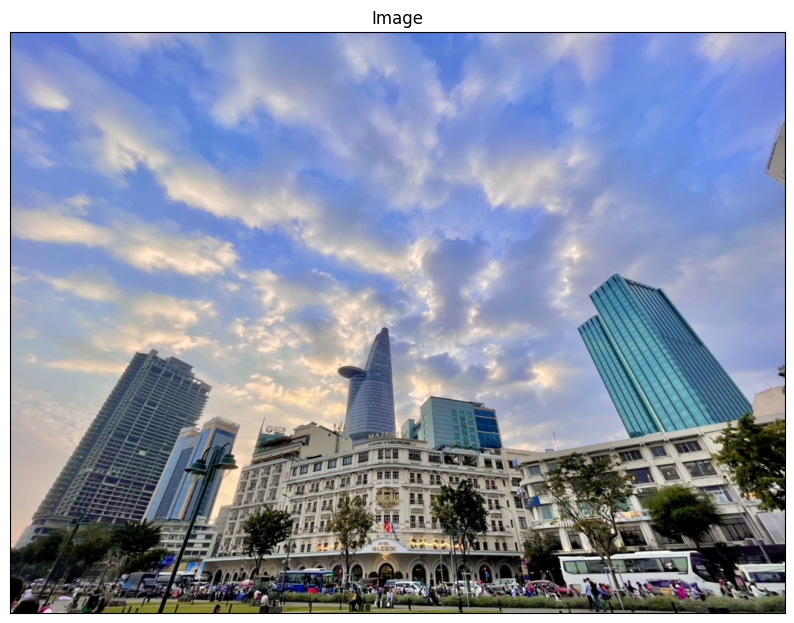

In [ ]:
import cv2
import numpy as np
from IPython.display import Image as cv2_imshow

img_src = np.array(img_list[0])
show_img(img_src)
img_des = np.array(img_list[1])
show_img(img_des)


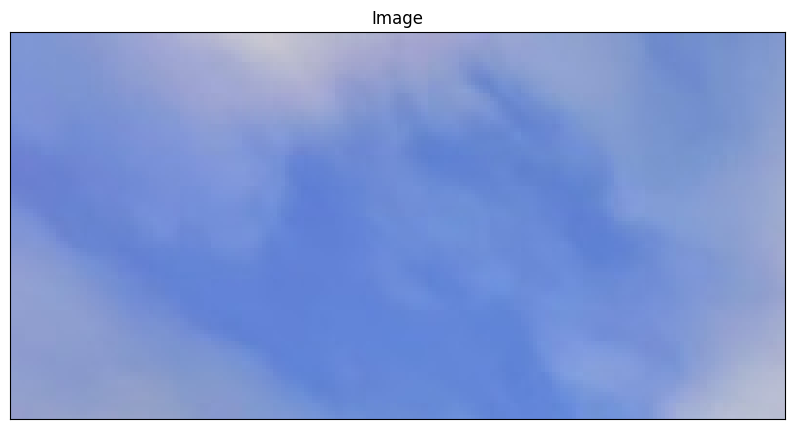

In [ ]:
import cv2
import numpy as np

# Kích thước của ROI
# Tâm của hình tròn
center_x, center_y = 200, 0

# Bán kính của hình tròn
radius = 100

# Tính toán tọa độ các đỉnh của hình chữ nhật bao quanh hình tròn
x1 = max(0, center_x - radius)
y1 = max(0, center_y - radius)
x2 = min(img_src.shape[1], center_x + radius)
y2 = min(img_src.shape[0], center_y + radius)

# Cắt ảnh ROI từ ảnh đích
roi_target = img_des[y1:y2, x1:x2]

# Hiển thị kết quả
show_img(roi_target)

# Cắt ảnh ROI từ ảnh đích và chuyển đổi kiểu dữ liệu về float64
roi_target = img_src[y1:y2, x1:x2].astype(np.float64)

# Tính gradient của ảnh nguồn và ảnh đích
gradient_source = cv2.Sobel(img_src, cv2.CV_64F, 1, 1, ksize=3)
gradient_target = cv2.Sobel(img_des, cv2.CV_64F, 1, 1, ksize=3)

# Resize gradient nguồn để phù hợp với kích thước của ROI và chuyển đổi kiểu dữ liệu về float64
gradient_source_resized = cv2.resize(gradient_source, (roi_target.shape[1], roi_target.shape[0])).astype(np.float64)

# Đảm bảo kích thước của gradient_target giống với gradient_source_resized và chuyển đổi kiểu dữ liệu về float64
gradient_target = cv2.resize(gradient_target, (roi_target.shape[1], roi_target.shape[0])).astype(np.float64)

# Kết hợp gradient và giải phương trình Poisson
result = cv2.add(roi_target, gradient_source_resized - gradient_target)

# Gán lại ảnh kết quả vào ảnh đích
img_des[y1:y2, x1:x2] = result.astype(np.uint8)


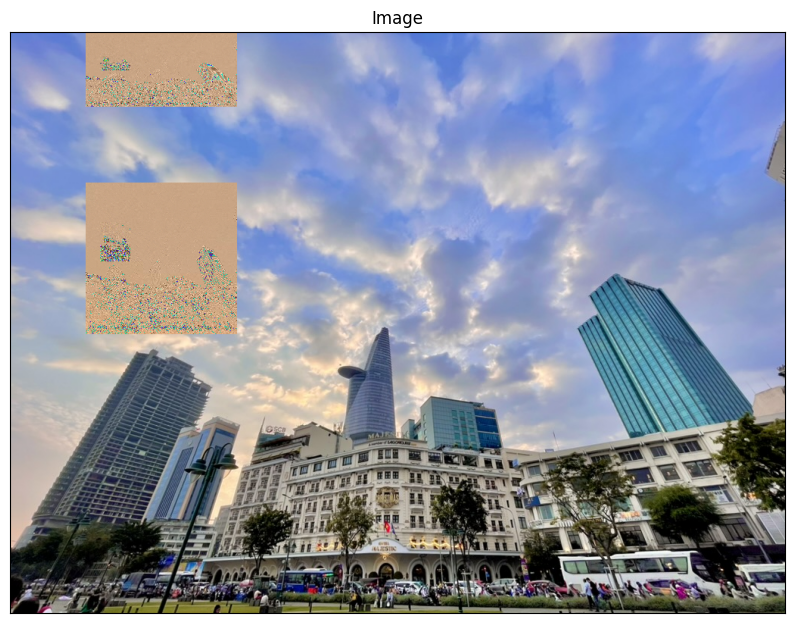

In [ ]:
show_img(img_des)

In [ ]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


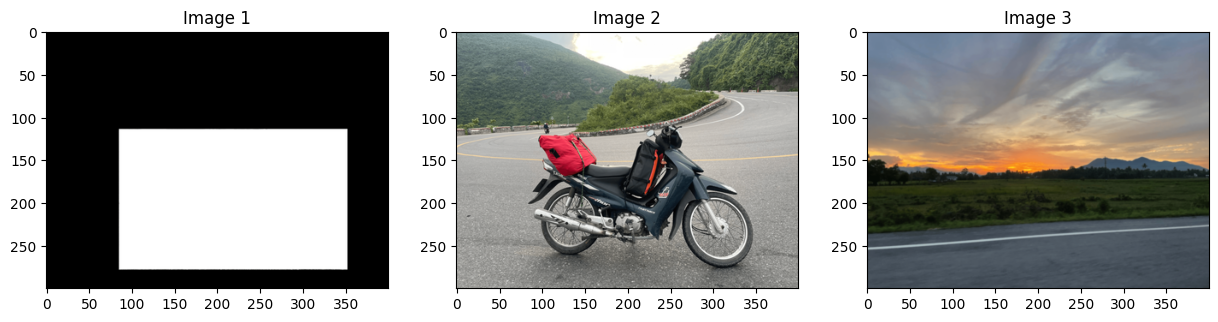

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Define the path to the images
path = '/content/drive/MyDrive/ColabNotebooks/ComputerVision/data1/'

# Load the images
image1 = mpimg.imread(path + '111.png')
image2 = mpimg.imread(path + '222.png')
image3 = mpimg.imread(path + '333.png')

# Display the images
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Image 1')

plt.subplot(1, 3, 2)
plt.imshow(image2)
plt.title('Image 2')

plt.subplot(1, 3, 3)
plt.imshow(image3)
plt.title('Image 3')

plt.show()


In [ ]:
import os
import cv2
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from skimage.segmentation import find_boundaries
import scipy.signal
import scipy.linalg
import scipy.sparse

class Util:
  def __init__(self): pass

  @staticmethod
  def read_image(folder, name, scale=1, gray=False):
      for filename in glob.glob(folder + "/*"):
          if os.path.splitext(os.path.basename(filename))[0] == name:
              break
      img = Image.open(os.path.join(filename))
      if scale != 1:
          w, h = img.size
          img = img.resize((int(w * scale), int(h * scale)), Image.BICUBIC)
      if gray:
          img = img.convert("L")
      img = np.array(img)
      if len(img.shape) == 3:
          img = img[..., :3]
      return img.astype(np.float64) / 255 # only first 3

  # def rgb2gray(img):
  #     r, g, b = img[..., 0], img[..., 1], img[..., 2]
  #     return 0.2126 * r + 0.7152 * g + 0.0722 * b

  @staticmethod
  def process_mask(mask):
      boundary = find_boundaries(mask, mode="inner").astype(int)
      inner = mask - boundary
      return inner, boundary
  @staticmethod
  def compute_laplacian(img):
      kernel = np.array([
          [0, 1, 0],
          [1, -4, 1],
          [0, 1, 0]
      ])
      laplacian = scipy.signal.fftconvolve(img, kernel, mode="same")
      return laplacian
  @staticmethod
  def compute_gradient(img, forward=True):
      if forward:
          kx = np.array([
              [0, 0, 0],
              [0, -1, 1],
              [0, 0, 0]
          ])
          ky = np.array([
              [0, 0, 0],
              [0, -1, 0],
              [0, 1, 0]
          ])
      else:
          kx = np.array([
              [0, 0, 0],
              [-1, 1, 0],
              [0, 0, 0]
          ])
          ky = np.array([
              [0, -1, 0],
              [0, 1, 0],
              [0, 0, 0]
          ])
      Gx = scipy.signal.fftconvolve(img, kx, mode="same")
      Gy = scipy.signal.fftconvolve(img, ky, mode="same")
      return Gx, Gy
  @staticmethod
  def get_pixel_ids(img):
      pixel_ids = np.arange(img.shape[0] * img.shape[1]).reshape(img.shape[0], img.shape[1])
      return pixel_ids
  @staticmethod
  def get_masked_values(values, mask):
      assert values.shape == mask.shape
      nonzero_idx = np.nonzero(mask) # get mask 1
      return values[nonzero_idx]
  @staticmethod
  def get_alpha_blended_img(src, target, alpha_mask):
      return src * alpha_mask + target * (1 - alpha_mask)
  @staticmethod
  def dilate_img(img, k):
      kernel = np.ones((k, k), np.uint8)
      return cv2.dilate(img, kernel, iterations = 1)
  @staticmethod
  def estimate_sparse_rank(A):
      def mv(v):
          return A @ v
      L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=mv, rmatvec=mv)
      rank = scipy.linalg.interpolative.estimate_rank(L, 0.1)
      return rank

In [ ]:
import os
import cv2
import numpy as np
import scipy.sparse.linalg
from PIL import Image
import matplotlib.pyplot as plt
from argparse import ArgumentParser


utils = Util()

class PoissonSeamlessCloner:

    def __init__(self, dataset_root, solver, scale):
        self.mask = utils.read_image(f"{dataset_root}", "111", scale=scale, gray=True)
        self.src_rgb = utils.read_image(f"{dataset_root}", "222", scale=scale, gray=False)
        self.target_rgb = utils.read_image(f"{dataset_root}", "333", scale=scale,  gray=False)

        self.solver = solver
        if solver != "multigrid":
            self.solver_func = getattr(scipy.sparse.linalg, solver)
        else:
            self.solver_func = None

        self.img_h, self.img_w = self.mask.shape

        _, self.mask = cv2.threshold(self.mask, 0.5, 1, cv2.THRESH_BINARY) # fix here
        self.inner_mask, self.boundary_mask = utils.process_mask(self.mask)

        self.pixel_ids = utils.get_pixel_ids(self.mask)
        self.inner_ids = utils.get_masked_values(self.pixel_ids, self.inner_mask).flatten()
        self.boundary_ids = utils.get_masked_values(self.pixel_ids, self.boundary_mask).flatten()
        self.mask_ids = utils.get_masked_values(self.pixel_ids, self.mask).flatten() # boundary + inner

        self.inner_pos = np.searchsorted(self.mask_ids, self.inner_ids)
        self.boundary_pos = np.searchsorted(self.mask_ids, self.boundary_ids)
        self.mask_pos = np.searchsorted(self.pixel_ids.flatten(), self.mask_ids)

    def construct_C_matrix(self):
        n1_pos = np.searchsorted(self.mask_ids, self.inner_ids - 1)
        n2_pos = np.searchsorted(self.mask_ids, self.inner_ids + 1)
        n3_pos = np.searchsorted(self.mask_ids, self.inner_ids - self.img_w)
        n4_pos = np.searchsorted(self.mask_ids, self.inner_ids + self.img_w)
        l = len(self.mask_ids)
        row_ids = np.concatenate([
            self.inner_pos, self.inner_pos, self.inner_pos, self.inner_pos, self.inner_pos, self.boundary_pos,
            l + self.inner_pos, l + self.inner_pos, l + self.inner_pos, l + self.inner_pos, l + self.inner_pos, l + self.boundary_pos,
            2 * l + self.inner_pos, 2 * l + self.inner_pos, 2 * l + self.inner_pos, 2 * l + self.inner_pos, 2 * l + self.inner_pos, 2 * l + self.boundary_pos
        ])
        col_ids = np.concatenate([
            n1_pos, n2_pos, n3_pos, n4_pos, self.inner_pos, self.boundary_pos,
            l + n1_pos, l + n2_pos, l + n3_pos, l + n4_pos, l + self.inner_pos, l + self.boundary_pos,
            2 * l + n1_pos, 2 * l + n2_pos, 2 * l + n3_pos, 2 * l + n4_pos, 2 * l + self.inner_pos, 2 * l + self.boundary_pos
        ])
        data = ([1] * len(self.inner_pos) * 4 + [-4] * len(self.inner_pos) + [1] * len(self.boundary_pos)) * 3
        C = scipy.sparse.csr_matrix((data, (row_ids, col_ids)), shape=(3 * len(self.mask_ids), 3 * len(self.mask_ids)))

        return C

    def construct_A_matrix(self):

        n1_pos = np.searchsorted(self.mask_ids, self.inner_ids - 1)
        n2_pos = np.searchsorted(self.mask_ids, self.inner_ids + 1)
        n3_pos = np.searchsorted(self.mask_ids, self.inner_ids - self.img_w)
        n4_pos = np.searchsorted(self.mask_ids, self.inner_ids + self.img_w)

        #row_ids = np.concatenate([self.inner_pos, self.inner_pos, self.inner_pos, self.inner_pos, self.inner_pos, self.boundary_pos])
        #col_ids = np.concatenate([n1_pos, n2_pos, n3_pos, n4_pos, self.inner_pos, self.boundary_pos])
        #data = [1] * len(self.inner_pos) * 4 + [-4] * len(self.inner_pos) + [1] * len(self.boundary_pos)

        #A = scipy.sparse.csr_matrix((data, (row_ids, col_ids)), shape=(len(self.mask_ids), len(self.mask_ids)))

        A = scipy.sparse.lil_matrix((len(self.mask_ids), len(self.mask_ids)))
        A[self.inner_pos, n1_pos] = 1
        A[self.inner_pos, n2_pos] = 1
        A[self.inner_pos, n3_pos] = 1
        A[self.inner_pos, n4_pos] = 1
        A[self.inner_pos, self.inner_pos] = -4
        A[self.boundary_pos, self.boundary_pos] = 1
        A = A.tocsr()
        print("matrix A: ", A)
        return A

    def construct_b(self, inner_gradient_values, boundary_pixel_values):
        b = np.zeros(len(self.mask_ids))
        b[self.inner_pos] = inner_gradient_values
        b[self.boundary_pos] = boundary_pixel_values
        return b


    def compute_mixed_gradients(self, src, target, mode="max", alpha=1.0):
        if mode == "max":
            Ix_src, Iy_src = utils.compute_gradient(src)
            Ix_target, Iy_target = utils.compute_gradient(target)
            I_src_amp = (Ix_src**2 + Iy_src**2)**0.5
            I_target_amp = (Ix_target**2 + Iy_target**2)**0.5
            Ix = np.where(I_src_amp > I_target_amp, Ix_src, Ix_target)
            Iy = np.where(I_src_amp > I_target_amp, Iy_src, Iy_target)
            Ixx, _ = utils.compute_gradient(Ix, forward=False)
            _, Iyy = utils.compute_gradient(Iy, forward=False)
            print("compute mix gradients: Ixx + Iyy=", Ixx+ Iyy)
            return Ixx + Iyy
        elif mode == "alpha":
            src_laplacian = utils.compute_laplacian(src)
            target_laplacian = utils.compute_laplacian(target)
            return alpha * src_laplacian + (1 - alpha) * target_laplacian
        else:
            raise ValueError(f"Gradient mixing mode '{mode}' not supported!")


    def poisson_blend_channel(self, src, target, gradient_mixing_mode, gradient_mixing_alpha):
        mixed_gradients = self.compute_mixed_gradients(src, target, gradient_mixing_mode, gradient_mixing_alpha)

        boundary_pixel_values = utils.get_masked_values(target, self.boundary_mask).flatten()
        inner_gradient_values = utils.get_masked_values(mixed_gradients, self.inner_mask).flatten()

        # Construct b
        b = self.construct_b(inner_gradient_values, boundary_pixel_values)

        # Solve Ax = b
        if self.solver != "multigrid":
            x = self.solver_func(self.A, b)
            if isinstance(x, tuple): # solvers other than spsolve
                x = x[0]
                print("Solve x = ", x)
        else:
            # Use multigrid solver
            ml = pyamg.ruge_stuben_solver(self.A)
            x = ml.solve(b, tol=1e-10)
        new_src = np.zeros(src.size)
        new_src[self.mask_pos] = x
        new_src = new_src.reshape(src.shape)
        print("new src: ", new_src)
        poisson_blended_img = utils.get_alpha_blended_img(new_src, target, self.mask)

        poisson_blended_img = np.clip(poisson_blended_img, 0, 1)

        return poisson_blended_img


    def poisson_blend_rgb_v2(self, gradient_mixing_mode, gradient_mixing_alpha):
        self.C = self.construct_C_matrix()
        b_full = []
        for i in range(self.src_rgb.shape[-1]):
            src = self.src_rgb[..., i]
            target = self.target_rgb[..., i]
            mixed_gradients = self.compute_mixed_gradients(src, target, gradient_mixing_mode, gradient_mixing_alpha)
            boundary_pixel_values = utils.get_masked_values(target, self.boundary_mask).flatten()
            inner_gradient_values = utils.get_masked_values(mixed_gradients, self.inner_mask).flatten()
            b = self.construct_b(inner_gradient_values, boundary_pixel_values)
            b_full.append(b)
        b_full = np.concatenate(b_full)
        x = self.solver(self.C, b_full)#[0]
        x = x.reshape(3, -1).T
        new_src = np.zeros((self.img_w * self.img_h, 3))
        new_src[self.mask_pos, :] = x
        new_src = new_src.reshape(self.src_rgb.shape)
        poisson_blended_img = utils.get_alpha_blended_img(new_src, self.target_rgb, np.expand_dims(self.mask, -1))

        poisson_blended_img = np.clip(poisson_blended_img, 0, 1)

        return poisson_blended_img


    def poisson_blend_rgb(self, gradient_mixing_mode, gradient_mixing_alpha):
        self.A = self.construct_A_matrix()
        poisson_blended_img_rgb = []
        for i in range(self.src_rgb.shape[-1]):
            poisson_blended_img_rgb.append(
                self.poisson_blend_channel(
                    self.src_rgb[..., i], self.target_rgb[..., i],
                    gradient_mixing_mode, gradient_mixing_alpha
                )
            )
        return np.dstack(poisson_blended_img_rgb)


In [ ]:
cloner = PoissonSeamlessCloner(path, "spsolve", 1)

img = cloner.poisson_blend_rgb('max', 1)

img = (img * 255).astype(np.uint8)
Image.fromarray(img).save(os.path.join(path, "result.png"))

matrix A:    (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0
  :	:
  (43952, 43952)	1.0
  (43953, 43953)	1.0
  (43954, 43954)	1.0
  (43955, 43955)	1.0
  (43956, 43956)	1.0
  (43957, 43957)	1.0
  (43958, 43958)	1.0
  (43959, 43959)	1.0
  (43960, 43960)	1.0
  (43961, 43961)	1.0
  (43962, 43962)	1.0
  (43963, 43963)	1.0
  (43964, 43964)	1.0
  (43965, 43965)	1.0
  (43966, 43966)	1.0
  (43967, 43967)	1.0
  (43968, 43968)	1.0
  (43969, 43969)	1.0
  (43970, 43970)	1.0
  (43971, 43971)	1.0
  (43972, 43972)	1.0
  (43973, 43973)	1.0
  (43974, 43974)	1.0
  (43975, 43975)	1.0
  (43976, 43976)	1.0
compute mix gradients: Ixx + Iyy= [[-1.19607843e+00 -5.21568627e-01 -5.60784314e-01 ... -5.13725490e-01

In [ ]:
class PoissonSeamlessCloner:

    def __init__(self, dataset_root):
        self.mask = cv2.imread(os.path.join(dataset_root, "111.png"), cv2.IMREAD_GRAYSCALE)
        self.src_rgb = cv2.imread(os.path.join(dataset_root, "222.png"))
        self.target_rgb = cv2.imread(os.path.join(dataset_root, "333.png"))

        self.img_h, self.img_w = self.mask.shape

        _, self.mask = cv2.threshold(self.mask, 127, 255, cv2.THRESH_TOZERO)

    def poisson_blend_rgb(self):
        mixed_clone = cv2.seamlessClone(
            self.src_rgb, self.target_rgb, self.mask,
            (self.img_w // 2, self.img_h // 2), cv2.NORMAL_CLONE
        )
        return mixed_clone



cloner = PoissonSeamlessCloner(path)

img = cloner.poisson_blend_rgb()

#img = (img * 255).astype(np.uint8)
Image.fromarray(img).save(os.path.join(path, "444.png"))
